# Step-wise Feature selection
Forward step-wise selection of the best features to use, following a greedy approach.

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.base import clone
from matplotlib import colors
import copy

In [3]:
path = "features/"
filenames = ["symptoms.npz", "betweennes.npz", "community_count.npz", "community_size.npz", "ks_level_1.npz", "ks_level_2.npz"]
names = ["symptoms", "betweenness", "community_count", "community_size", "ks_level_1", "ks_level_2"]
sample_percentage = 0.1
parameters = {'C': 0.001, 'solver': 'liblinear'}
model = LogisticRegression(**parameters)

In [4]:
#load features from .npz files
labels = np.load(path + filenames[0])['y']
num_samples = int(labels.shape[0] * sample_percentage)
sampled_indices = np.random.choice(labels.shape[0], num_samples, replace=False)
labels = labels[sampled_indices]
features = []
for filename in filenames:
    file_path = path + filename
    data = np.load(file_path)
    feature_matrix = data['X']
    feature_matrix = feature_matrix[sampled_indices, :]
    features.append(feature_matrix)

In [ ]:
# Perform feature selection and record accuracies
num_features = len(features)
remaining_features = list(range(num_features))
already_used_features = []
accuracies = []

# Initial null model with the first feature
X_train, X_test, y_train, y_test = train_test_split(features[0], labels, test_size=0.2, random_state=42)
# Perform logistic regression and compute accuracy
model_ = clone(model)
model_.fit(X_train, y_train)
y_pred = model_.predict(X_test)
null_model_accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline model: accuracy = {null_model_accuracy*100:4.2f}.")
accuracies.append(null_model_accuracy)
remaining_features.pop(0)
already_used_features.append(0)

# Feature selection iterations
it = 0
accuracy_matrix = np.zeros((num_features-1, num_features-1))
while remaining_features:
    best_accuracy = 0
    best_feature = None

    for feature_index in remaining_features:
        current_features = already_used_features + [feature_index]
        X = np.hstack([features[i] for i in current_features])

        X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
        # Perform logistic regression and compute accuracy
        model_ = clone(model)
        model_.fit(X_train, y_train)
        y_pred = model_.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        accuracy_matrix[it][feature_index-1] = accuracy
        print(f"Model [{it}][{feature_index}]: accuracy = {accuracy*100:4.2f}.")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_feature = feature_index

    # Update lists
    accuracies.append(best_accuracy)
    remaining_features.remove(best_feature)
    already_used_features.append(best_feature)
    it += 1

In [6]:
already_used_features

[0, 3, 1, 2, 5, 4]

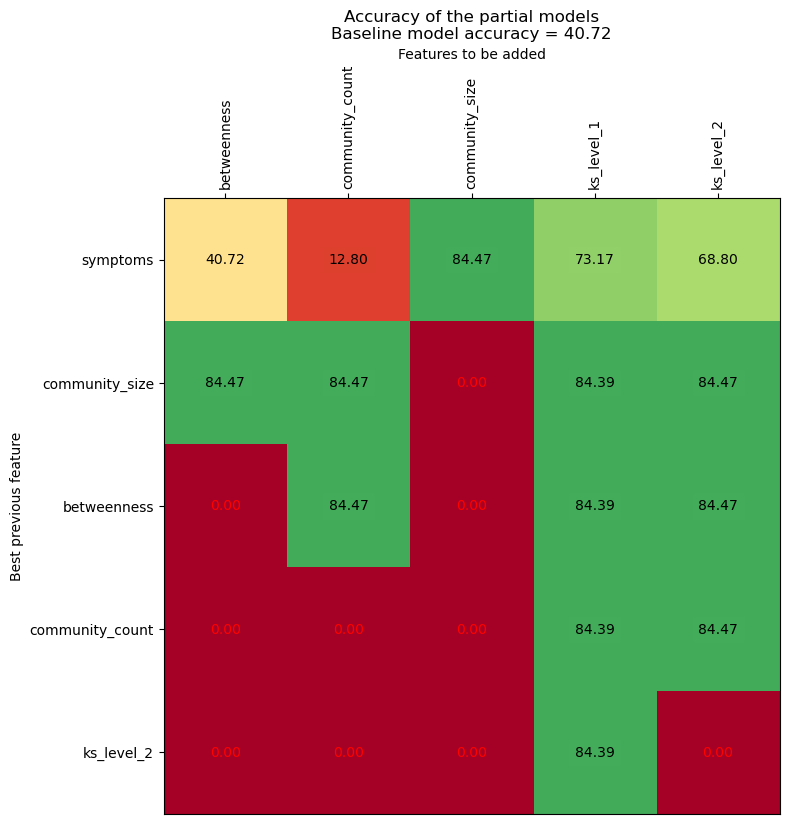

In [5]:
# Plot model accuracies with custom colormap
norm = colors.Normalize(vmin=-null_model_accuracy, vmax=1-null_model_accuracy)
cmap = plt.get_cmap('RdYlGn')
plt.figure(figsize=(8, 8))
plt.imshow(accuracy_matrix-null_model_accuracy, cmap=cmap, norm=norm)
tick_marks = np.arange(num_features-1)
reordered_names = [names[i] for i in already_used_features]
plt.xticks(tick_marks, labels=names[1:], rotation='vertical', ha='center')  # Set custom tick marks
plt.yticks(tick_marks, labels=reordered_names[:-1])
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xlabel("Features to be added")
plt.ylabel("Best previous feature")

# Add text with colored background based on the value
for i in range(num_features-1):
    for j in range(num_features-1):
        val = accuracy_matrix[i, j]
        color = cmap(norm(val-null_model_accuracy))
        plt.text(j, i, f"{val*100:4.2f}", ha='center', va='center', color='red' if val == 0 else 'black', backgroundcolor=color)

plt.title(f"Accuracy of the partial models\nBaseline model accuracy = {null_model_accuracy*100:4.2f}")
plt.show()

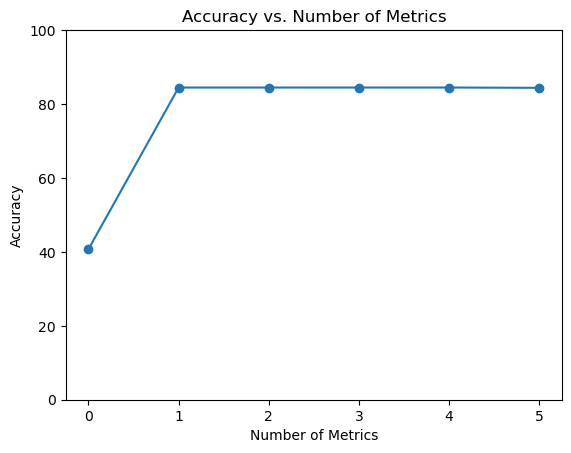

In [6]:
# Plot accuracies for each best model
plt.plot(range(len(accuracies)), np.array(accuracies)*100, marker='o')
plt.xlabel('Number of Metrics')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.title('Accuracy vs. Number of Metrics')
plt.show()

In [8]:
accuracies

[0.4126341364648714,
 0.8370115407977323,
 0.8374164810690423,
 0.8376189512046973,
 0.8376189512046973,
 0.8376189512046973]

# Feature selection based on Commonality

In [14]:
# Feature selection based on a specific criterion

# Compute the threshold
threshold_feature = "ks_level_2"

thr_data_unsampled = np.load(path+threshold_feature+".npz")
thr_data = thr_data_unsampled['X'][sampled_indices, :]

percentiles = np.percentile(np.mean(thr_data, axis=1), np.geomspace(50, 1e-6, 10), axis=0)

used_features = copy.deepcopy([features[i] for i in already_used_features[:np.argmax(accuracies)]])

accuracies_filt = []
percentages = []
for perc in percentiles:
    filtered_coefficients = np.where(np.mean(thr_data, axis=0) > perc)[0]
    if filtered_coefficients.size == 0:
        continue
    X = np.hstack([f[:, filtered_coefficients] for f in used_features])
    data_percentage = filtered_coefficients.shape[0]/thr_data.shape[1]

    # Perform logistic regression and compute accuracy
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
    model_ = clone(model)
    model_.fit(X_train, y_train)
    y_pred = model_.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy = {accuracy*100:4.2f}; retained features = {data_percentage*100:4.2f}%")
    accuracies_filt.append(accuracy)
    percentages.append(data_percentage)

Accuracy = 62.87; retained features = 33.54%
Accuracy = 73.68; retained features = 49.09%
Accuracy = 79.79; retained features = 61.89%
Accuracy = 82.00; retained features = 70.73%
Accuracy = 82.63; retained features = 74.39%
Accuracy = 82.87; retained features = 76.83%
Accuracy = 83.15; retained features = 81.71%
Accuracy = 83.15; retained features = 82.01%
Accuracy = 83.15; retained features = 82.01%
Accuracy = 83.15; retained features = 82.01%


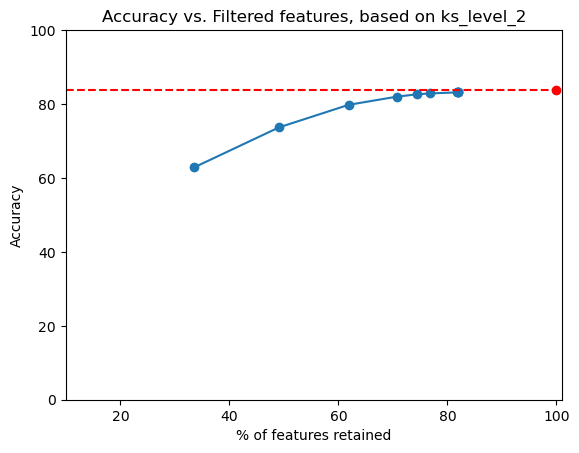

In [15]:
# Plot accuracies for each model
plt.plot(np.array(percentages)*100, np.array(accuracies_filt)*100, marker='o')
plt.axhline(y=np.max(accuracies)*100, color='r', linestyle='--', label='')
plt.plot(100, np.max(accuracies)*100, color='r', marker='o')
plt.xlabel('% of features retained')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.xlim(10, 101)
plt.title('Accuracy vs. Filtered features, based on '+threshold_feature)
plt.show()

# Feature selection based on Occurrence

In [16]:
# Feature selection based on a specific criterion

# Compute the threshold
threshold_feature1 = "ks_level_1"

thr_data_unsampled1 = np.load(path+threshold_feature1+".npz")
thr_data1 = thr_data_unsampled1['X'][sampled_indices, :]

percentiles1 = np.percentile(np.mean(thr_data1, axis=1), np.geomspace(50, 1e-6, 10), axis=0)

used_features1 = copy.deepcopy([features[i] for i in already_used_features[:np.argmax(accuracies)]])

accuracies_filt1 = []
percentages1 = []
for perc in percentiles1:
    filtered_coefficients = np.where(np.mean(thr_data1, axis=0) > perc)[0]
    if filtered_coefficients.size == 0:
        continue
    X = np.hstack([f[:, filtered_coefficients] for f in used_features1])
    data_percentage = filtered_coefficients.shape[0]/thr_data1.shape[1]

    # Perform logistic regression and compute accuracy
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
    model_ = clone(model)
    model_.fit(X_train, y_train)
    y_pred = model_.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy = {accuracy*100:4.2f}; retained features = {data_percentage*100:4.2f}%")
    accuracies_filt1.append(accuracy)
    percentages1.append(data_percentage)

Accuracy = 45.52; retained features = 22.26%
Accuracy = 62.91; retained features = 33.84%
Accuracy = 69.91; retained features = 42.07%
Accuracy = 77.75; retained features = 55.18%
Accuracy = 80.02; retained features = 63.11%
Accuracy = 81.01; retained features = 66.77%
Accuracy = 82.12; retained features = 71.65%
Accuracy = 82.36; retained features = 72.56%
Accuracy = 82.41; retained features = 72.87%
Accuracy = 82.41; retained features = 72.87%


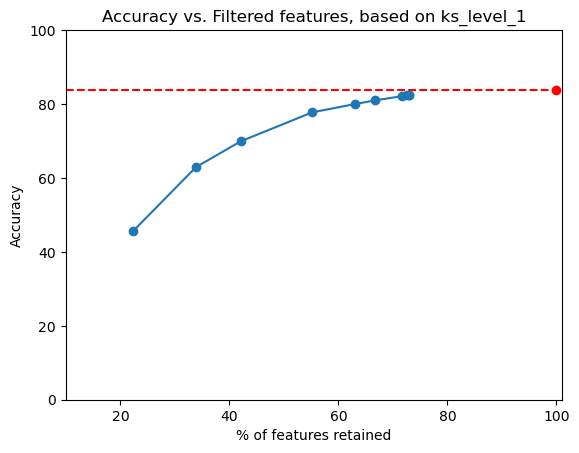

In [17]:
# Plot accuracies for each model
plt.plot(np.array(percentages1)*100, np.array(accuracies_filt1)*100, marker='o')
plt.axhline(y=np.max(accuracies)*100, color='r', linestyle='--', label='')
plt.plot(100, np.max(accuracies)*100, color='r', marker='o')
plt.xlabel('% of features retained')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.xlim(10, 101)
plt.title('Accuracy vs. Filtered features, based on '+threshold_feature1)
plt.show()